This example is partially based on https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

Copyright 2018 The TensorFlow Authors.  All rights reserved.
Copyright 2023 Ivan Vasilev.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

Install the dependencies:

In [1]:
!pip install tensorflow

Load the training and testing datasets:

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 50

import tensorflow as tf
import tensorflow_datasets as tfds

data, metadata = tfds.load('cifar10', with_info=True, as_supervised=True)
raw_train, raw_test = data['train'].repeat(), data['test'].repeat()

Define the input transformations (per sample) for the training and validation phases:

In [3]:
def train_format_sample(image, label):
    """Transform data for training"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    label = tf.one_hot(label, metadata.features['label'].num_classes)

    return image, label


def test_format_sample(image, label):
    """Transform data for testing"""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    label = tf.one_hot(label, metadata.features['label'].num_classes)

    return image, label

Assign transformers to raw data:

In [4]:
train_data = raw_train.map(train_format_sample)
test_data = raw_test.map(test_format_sample)

Extract batches from the training set:

In [5]:
train_batches = train_data.shuffle(1000).batch(BATCH_SIZE)
test_batches = test_data.batch(BATCH_SIZE)

Define 2 functions that build transfer learning models for either feature extacting, or fine-tuning. Both models use the tf.keras.applications.MobileNetV3Small ImageNet pretrained model. We’ll start with feature extracting, which “locks” all model parameters (weights) except for the final fully-connected layer:

In [6]:
def build_fe_model():
    """"Create feature extraction model from the pre-trained model MobileNetV3Small"""

    # create the pre-trained part of the network, excluding FC layers
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        classes=10,
        weights='imagenet',
        include_preprocessing=True)

    # exclude all model layers from training
    base_model.trainable = False

    # create new model as a combination of the pre-trained net
    # and one fully connected layer at the top
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(
            metadata.features['label'].num_classes,
            activation='softmax')
    ])

Continue with the fine-tuning model, which locks the first `fine_tune_at` layers, but trains all other model parameters:


In [7]:
def build_ft_model():
    """"Create fine tuning model from the pre-trained model MobileNetV3Small"""

    # create the pre-trained part of the network, excluding FC layers
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        include_preprocessing=True
    )

    # Fine tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # create new model as a combination of the pre-trained net
    # and one fully connected layer at the top
    return tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(
            metadata.features['label'].num_classes,
            activation='softmax')
    ])

Define the `train_model` function, which builds takes the pre-built model, fits it over the training data, and plots the training and validation results. The function is shared for both feature extraction and fine-tuning:

In [8]:
def train_model(model, epochs=5):
    """Train the model. This function is shared for both FE and FT modes"""

    # configure the model for training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    # train the model
    history = model.fit(
        train_batches,
        epochs=epochs,
        steps_per_epoch=metadata.splits['train'].num_examples // BATCH_SIZE,
        validation_data=test_batches,
        validation_steps=metadata.splits['test'].num_examples // BATCH_SIZE,
        workers=4)

    # plot accuracy
    plot_accuracy(history.history['val_accuracy'])

import matplotlib.pyplot as plt

def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

We can now run the training procedure. Let's start by building the feature extraction model:

In [9]:
model = build_fe_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                5770      
                                                                 
Total params: 944890 (3.60 MB)
Trainable params: 5770 (22.54 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


Run the training:

Epoch 1/5
1000/1000 [==============================] - 36s 29ms/step - loss: 1.4821 - accuracy: 0.5125 - val_loss: 0.9105 - val_accuracy: 0.7289
Epoch 2/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.9070 - accuracy: 0.7093 - val_loss: 0.6917 - val_accuracy: 0.7849
Epoch 3/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.7753 - accuracy: 0.7466 - val_loss: 0.6067 - val_accuracy: 0.8063
Epoch 4/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.7087 - accuracy: 0.7649 - val_loss: 0.5626 - val_accuracy: 0.8181
Epoch 5/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.6714 - accuracy: 0.7736 - val_loss: 0.5331 - val_accuracy: 0.8258


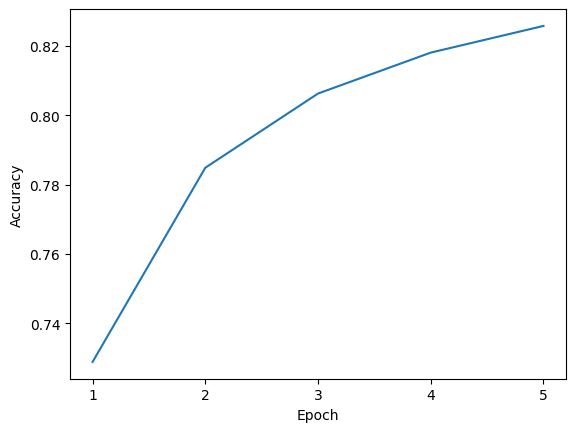

In [10]:
train_model(model)


We can also try the fine-tuning model for comparison:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 10)                5770      
                                                                 
Total params: 944890 (3.60 MB)
Trainable params: 819306 (3.13 MB)
Non-trainable params: 125584 (490.56 KB)
_________________________________________________________________
Epoch 1/5
1000/1000 [==============================] - 52s 33ms/step - loss: 0.6928 - accuracy: 0.7624 - val_loss: 0.5052 - val_accuracy: 0.8238


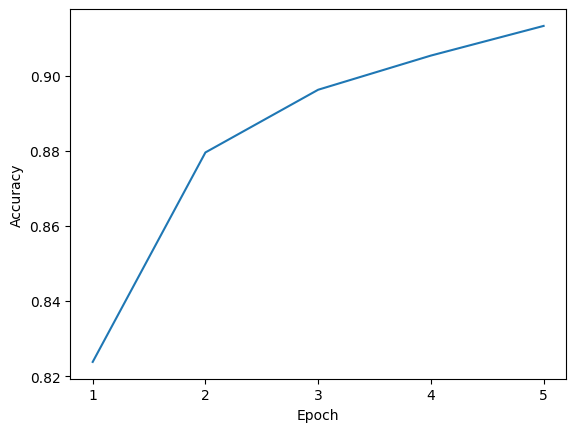

In [11]:
model = build_ft_model()
model.summary()
train_model(model)